# Pytorch多层感知机分类MNIST数据集

使用深度学习框架Pytorch搭建两层多层感知机MLP神经网络，对MINIST手写数字数据集进行图像分类。
1. 载入数据集
1. 可视化数据集
1. 定义神经网络、损失函数、优化器
1. 训练神经网络，观察训练误差和验证误差变化
1. 在测试集上评估模型分类效果

# 导入库

In [1]:
# 忽略后续运行代码时出现的烦人红色提醒
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 导入深度学习框架pytorch和科学计算库numpy
import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

# 导入MNIST数据集

Pytorch文档：http://pytorch.org/docs/stable/torchVision/datasets.html

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# 载入数据时使用的处理器个数
num_workers = 0

# 每一批的数据个数
batch_size = 20

# 验证集所占比例
valid_size = 0.2

# 将数据转化为Pytorch的张量Tensor类型
transform = transforms.ToTensor()

# 选择训练集和测试集
# root：数据集文件根目录 放在当前目录下的data文件夹，这里是data/MNIST/raw
# train：是否载入训练集
# download：如果目录中找不到数据集，是否自动下载
# transform：将载入的数据按上面transform定义的方式进行转换
train_data = datasets.MNIST(root='data', train=True,
                           download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                           download=True, transform=transform)

# 将训练集每张图像对应的索引随机打乱，将索引分为训练集索引和验证集索引
# 打乱索引，然后用采样器把打乱后的索引所对应的图片找到
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))  # 切片 取出验证集
train_idx, valid_idx = indices[split:],indices[:split]

# 划分为新的训练集和验证集，用采样器把打乱后的索引所对应的图片找到
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# 创建训练集、验证集、测试集的数据Loader，python中的生成器，每一次调用返回一个batch的数据
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# 可视化数据

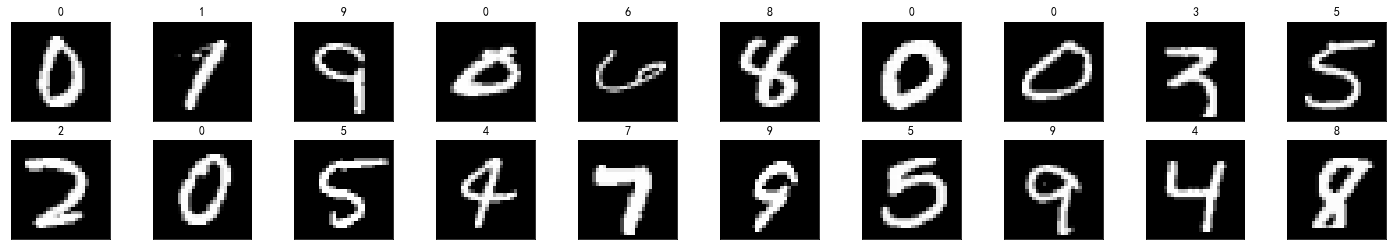

In [4]:
# 可重复运行展示不同的图片

# 构造迭代器，获得训练集中的一批次数据
dataiter = iter(train_loader)
images, labels = dataiter.next()
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

# 可视化图片和标签
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # .item()获取张量的数值
    ax.set_title(str(labels[idx].item()))

# 展示图片的像素细节

In [5]:
images[1].shape

(1, 28, 28)

In [6]:
np.squeeze(images[1]).shape

(28, 28)

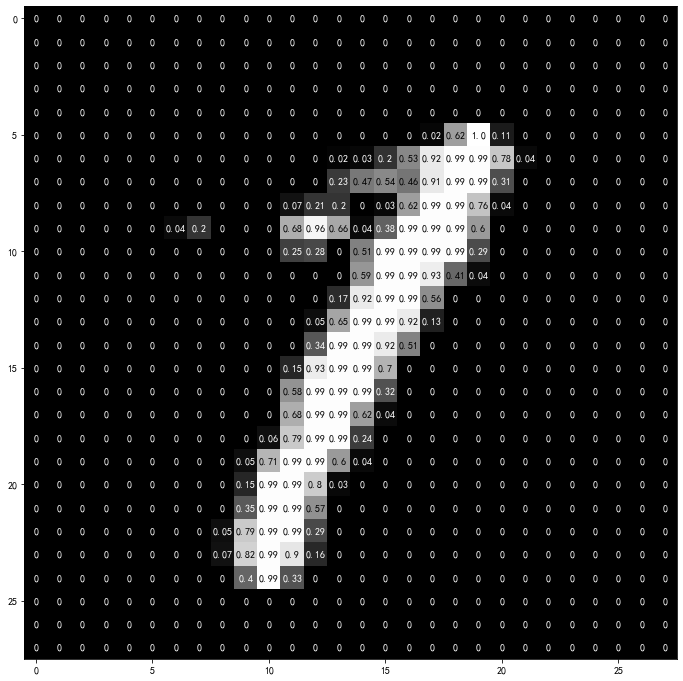

In [7]:
# 去掉图像的批次维度，只保留索引为1的单张图像的长宽像素值
img = np.squeeze(images[1])

# 把图片画出来
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

# 遍历并输出每一行每一列的每一个像素值
for x in range(width):
    for y in range(height):
        # 像素值保留两位小数，如果为0则显示0
        val = round(img[x][y], 2) if img[x][y] != 0 else 0
        ax.annotate(str(val), xy=(y,x),
                   horizontalalignment='center',
                   verticalalignment='center',
                   size=10,
                   color='white' if img[x][y]<thresh else 'black')

# 定义神经网络结构

输入为784维的向量，输出为10个数字对应的概率。

中间是两层隐含层，每个隐含层都有512个神经元。

采用Dropout防止过拟合。

Pytorch文档：http://pytroch.org/docs/stable/nn.html<br>
![MLP_多层感知机](https://user-images.githubusercontent.com/43770754/150680460-42999629-4b64-4aff-a0cd-5fdf4219643c.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义第一个隐含层和第二个隐含层的神经元个数
        hidden_1 = 512
        hidden_2 = 512
        
        # 输入层到隐含层，输入维度为 784=28*28，输出维度为hidden_1
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # 第一层隐含层到第二层隐含层，输入维度为hidden_1，输出维度为hidden_2
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # 第二层隐含层到输出层，输入维度为hidden_2，输出维度为10
        self.fc3 = nn.Linear(hidden_2, 10)
        # 定义Dropout率为0.2，防止过拟合——随机掐死神经元
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # 将原始图像拉平成784维的长向量
        x = x.view(-1, 28 * 28)
        # 经过第一层隐含层，激活函数为relu
        x = F.relu(self.fc1(x))
        # Dropout层
        x = self.dropout(x)
        # 经过第二层隐含层，激活函数为relu
        x = F.relu(self.fc2(x))
        # Dropout层
        x = self.dropout(x)
        # 输出层
        x = self.fc3(x)
        return x
    
# 实例化模型，打印模型信息
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# 定义损失函数和梯度下降优化器

使用交叉熵作为分类问题的损失函数，从Pytorch文档可知，Pytorch中的交叉熵其实包含了softmax和对数损失的计算。

Pytorch文档-损失函数：http://pytorch.org/docs/stable/nn.html#loss-functions &emsp; Pytorch文档-梯度下降优化器：http://pytorch.org/docs/stable/optim.html

In [9]:
# 损失函数为交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器(随机梯度下降SGD优化器，学习率0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 训练神经网络

1. 清除所有梯度 `optimizer.zero_grad()`
1. 正向预测，求出模型对训练集数据的预测分类 `output = model(data)`
1. 计算损失函数 `loss = criterion(output, target)`
1. 反向传播，将损失函数对每一个权重求导，求得每个权重对应的梯度 `loss.backward()`
1. 优化器执行单步的优化（权重更新） `optimizer.step()`
1. 计算每一轮的平均训练误差和验证误差 

In [10]:
len(train_loader.dataset)

60000

In [11]:
# 训练轮次数，每一轮都完整遍历数据集中的所有图像
n_epochs = 50

# 初始化验证集的最小误差
valid_loss_min = np.Inf

# 将训练过程中的训练损失和验证损失存储在列表中
train_loss_list = []
val_loss_list = []

# 每一轮训练： epoch 轮次
for epoch in range(n_epochs):
    # 初始化训练损失和验证损失
    train_loss = 0.0
    valid_loss = 0.0
    
    #################
    #    训练阶段   #
    #################
    model.train()  # 将模型调节为训练模式
    
    # 从train_loader中获取一批次的数据和标签
    for data, target in train_loader:
        # 将所有梯度归零
        optimizer.zero_grad()
        # 正向判断，求得预测结果————判断
        output = model(data)
        # 将预测的结果与标签进行比较，求得交叉熵损失函数值
        loss = criterion(output, target)
        # 反向传播，将损失函数对每一个权重求导，求得每个权重对应的梯度
        loss.backward()
        # 优化器执行单步优化操作（权重更新）
        optimizer.step()
        # 将本批次的所有样本的损失函数值求和，作为本次训练的损失
        train_loss += loss.item() * data.size(0)
        
    #################
    #    验证阶段   #
    #################
    model.eval() # 将模型调整到验证阶段，此时需要关闭Dropout和BN层  BN：批量归一化
    
    # 从valid_loader中获得一个批次的数据及标签
    for data, target in valid_loader:
        # 正向预测，预测每张图片的分类————预测
        output = model(data)
        # 计算交叉熵损失函数
        loss = criterion(output, target)
        # 将本批次的所有样本的损失函数求和，作为验证损失
        valid_loss += loss.item()*data.size(0)
        
    # 结束了本轮的训练和验证，打印训练和验证指标
    # 计算平均训练损失和平均验证损失，存储在列表中
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_loss_list.append(train_loss)  # 将整个对象加在列表末尾
    val_loss_list.append(valid_loss)

    print('第{}轮 \t训练损失：{:.6f} \t验证损失：{:.6f}'.format(epoch+1, train_loss, valid_loss))

    # 如果验证误差相比上一轮有降低，及时保存模型在本地的model.pt文件中
    if valid_loss <= valid_loss_min:
        print('验证损失相比之前降低了 （{:.6f} --> {:.6f}).  保存模型'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(),'model.pt')
        valid_loss_min = valid_loss




第1轮 	训练损失：0.758580 	验证损失：0.075954
验证损失相比之前降低了 （inf --> 0.075954).  保存模型
第2轮 	训练损失：0.284166 	验证损失：0.059191
验证损失相比之前降低了 （0.075954 --> 0.059191).  保存模型
第3轮 	训练损失：0.224392 	验证损失：0.049542
验证损失相比之前降低了 （0.059191 --> 0.049542).  保存模型
第4轮 	训练损失：0.184694 	验证损失：0.042235
验证损失相比之前降低了 （0.049542 --> 0.042235).  保存模型
第5轮 	训练损失：0.155347 	验证损失：0.036710
验证损失相比之前降低了 （0.042235 --> 0.036710).  保存模型
第6轮 	训练损失：0.135067 	验证损失：0.033626
验证损失相比之前降低了 （0.036710 --> 0.033626).  保存模型
第7轮 	训练损失：0.120174 	验证损失：0.029658
验证损失相比之前降低了 （0.033626 --> 0.029658).  保存模型
第8轮 	训练损失：0.106627 	验证损失：0.027300
验证损失相比之前降低了 （0.029658 --> 0.027300).  保存模型
第9轮 	训练损失：0.096307 	验证损失：0.025133
验证损失相比之前降低了 （0.027300 --> 0.025133).  保存模型
第10轮 	训练损失：0.086700 	验证损失：0.023886
验证损失相比之前降低了 （0.025133 --> 0.023886).  保存模型
第11轮 	训练损失：0.079700 	验证损失：0.022450
验证损失相比之前降低了 （0.023886 --> 0.022450).  保存模型
第12轮 	训练损失：0.073076 	验证损失：0.021370
验证损失相比之前降低了 （0.022450 --> 0.021370).  保存模型
第13轮 	训练损失：0.067812 	验证损失：0.020643
验证损失相比之前降低了 （0.021370 --> 0.020643).  保存模型


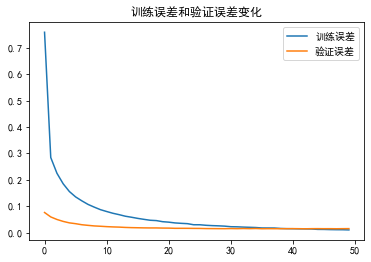

In [12]:
plt.plot(train_loss_list,label='训练误差')
plt.plot(val_loss_list,label='验证误差')
plt.legend()
plt.title('训练误差和验证误差变化')
plt.show()

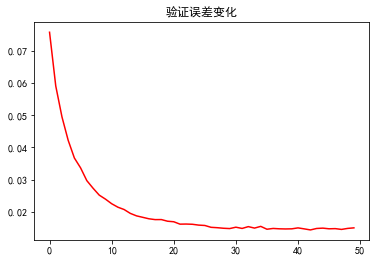

In [13]:
plt.plot(val_loss_list,label='验证误差',c='r')
plt.title('验证误差变化')
plt.show()

# 载入验证集损失最低的模型

In [14]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

# 在测试集上评估模型分类效果

测试集是模型之前没有见过的数据，相当于高考试题，因此可以检验模型的泛化能力。

分析每种数据的识别准确率，我们还可以细粒度地分析模型性能

## 对测试集中一个batch地数据进行评估

In [15]:
# 初始化测试误差
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [16]:
# 存储每种数字正确识别的个数
class_correct

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [17]:
# 存储每种数字总的样本数
class_total

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [18]:
# 用迭代器的方法获取20个数据和20个标签
dataiter = iter(train_loader)
data, target = dataiter.next()

In [19]:
target.shape

torch.Size([20])

In [20]:
target

tensor([4, 4, 1, 0, 4, 1, 2, 9, 6, 0, 8, 2, 7, 1, 4, 5, 1, 4, 2, 3])

In [21]:
# 将模型调整到验证阶段，关闭Dropout和BN层
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [22]:
# 正向预测，预测每张图片的分类
output = model(data)

In [23]:
output.shape

torch.Size([20, 10])

In [24]:
output[0]

tensor([-0.1293, -4.7278,  0.8763, -8.0118, 17.2259, -3.6859,  2.9831,  0.6214,
        -3.2792, -1.7150], grad_fn=<SelectBackward0>)

In [25]:
# 计算交叉熵损失函数
loss = criterion(output, target)

In [26]:
loss

tensor(0.0041, grad_fn=<NllLossBackward0>)

In [27]:
# 将本批次所有样本的损失函数值求和，作为测试损失
test_loss += loss.item()*data.size(0)

In [28]:
test_loss

0.08242559619247913

In [29]:
# 将输出最大值对应的神经元作为预测分类
_, pred = torch.max(output, 1)

In [30]:
pred

tensor([4, 4, 1, 0, 4, 1, 2, 9, 6, 0, 8, 2, 7, 1, 4, 5, 1, 4, 2, 3])

In [31]:
target

tensor([4, 4, 1, 0, 4, 1, 2, 9, 6, 0, 8, 2, 7, 1, 4, 5, 1, 4, 2, 3])

In [32]:
# 比较预测的分类和真实标签，如果相等则取1
correct = np.squeeze(pred.eq(target.data.view_as(pred)))

In [33]:
correct

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

In [34]:
# 遍历本batch中的所有数字，将correct加到每个数字对应的正确识别个数上
for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

In [35]:
# 每一种数字有多少被分类正确了
class_correct

[2.0, 4.0, 3.0, 1.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [36]:
# 每一种数字总共有多少样本
class_total

[2.0, 4.0, 3.0, 1.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0]

## 对整个测试集进行评估

In [37]:
model.eval() # 将模型调整到

# 从测试集中取出一个batch的数据和标签
for data, target in test_loader:
    # 正向预测，预测每张图片的分类
    output = model(data)
    # 计算交叉熵损失函数
    loss = criterion(output, target)
    # 及那个本批次的所有样本的损失函数值求和，作为测试损失
    test_loss += loss.item()*data.size(0)
    # 将输出最大值对应的神经元作为预测分类
    _, pred = torch.max(output, 1)
    # 对比预测集标签和真实标签
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # 计算每个对象类的测试精度
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# 计算平均测试误差
test_loss = test_loss/len(test_loader.dataset)
print('测试机上的误差：{:.6f}'.format(test_loss))

测试机上的误差：0.061084


In [38]:
class_correct

[973.0, 1130.0, 1009.0, 994.0, 966.0, 873.0, 940.0, 1005.0, 952.0, 984.0]

In [39]:
class_total

[982.0, 1139.0, 1035.0, 1011.0, 987.0, 893.0, 959.0, 1029.0, 975.0, 1010.0]

In [40]:
for i in range(10):
    print('数字 {} 在测试集上的识别正确率为  {:.5f}%  ({:.0f}/{:.0f})'.format(i,class_correct[i]*100/class_total[i],class_correct[i],class_total[i]))

数字 0 在测试集上的识别正确率为  99.08350%  (973/982)
数字 1 在测试集上的识别正确率为  99.20983%  (1130/1139)
数字 2 在测试集上的识别正确率为  97.48792%  (1009/1035)
数字 3 在测试集上的识别正确率为  98.31850%  (994/1011)
数字 4 在测试集上的识别正确率为  97.87234%  (966/987)
数字 5 在测试集上的识别正确率为  97.76036%  (873/893)
数字 6 在测试集上的识别正确率为  98.01877%  (940/959)
数字 7 在测试集上的识别正确率为  97.66764%  (1005/1029)
数字 8 在测试集上的识别正确率为  97.64103%  (952/975)
数字 9 在测试集上的识别正确率为  97.42574%  (984/1010)


## 可视化测试集中一些图片和预测结果

括号里为真实标签，如果识别正确为绿色，如果识别错误为红色。

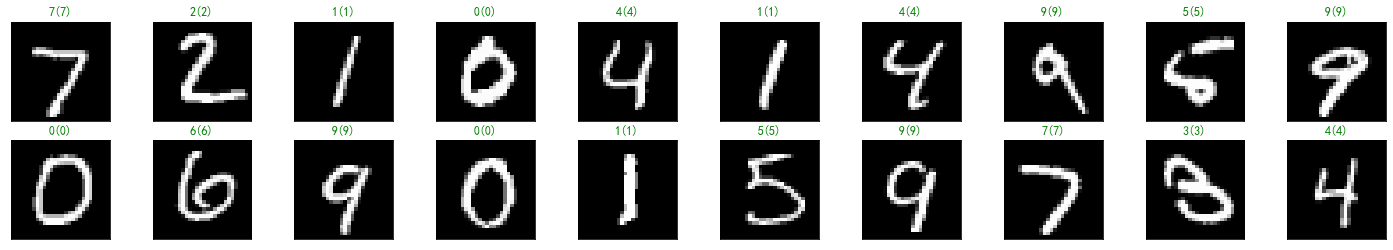

In [50]:
# 获得测试机的一个batch的数据和标签
dataiter = iter(test_loader)  # 把载入器变成一个迭代器
images, labels = dataiter.next()

# 正向推断
output = model(images)
# 取概率最高的分类作为分类结果
_, preds = torch.max(output, 1)
# 将数据从Torch张量转换为numpy的array
images = images.numpy()

# 可视化本batch中图片、预测种类、真实种类
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{}({})".format(str(preds[idx].item()), str(labels[idx].item())),
                color=("green" if preds[idx] == labels[idx] else "red"))